# Model Training & Testing
This notebook is intended to help train and test various models, and expanded from our data_model_prep notebook.

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

from tqdm.notebook import tqdm

import os
import pickle

random_state = 42

## Set up paths

In [10]:
# For python pipeline that will be run from root folder of project
# ROOT_DIR = os.path.abspath(os.curdir)

# # Pickle save paths
# training_df_path = os.path.join(ROOT_DIR,"data/processed/training_df.pkl")
# testing_df_path = os.path.join(ROOT_DIR,"data/processed/testing_df.pkl")

# Relative path for notebook
training_df_path = "../data/processed/training_df.pkl"
testing_df_path = "../data/processed/testing_df.pkl"

## Load training and test dataframes

In [12]:
training_df = pd.read_pickle(training_df_path)
testing_df = pd.read_pickle(testing_df_path)

## Columns for model training

In [13]:
# Based on what we can get at inference time from the Youtube API or scraping
X_cols = [
    "duration",
    "age_limit",
    "view_count",
    "like_count",
    "view_like_ratio",
    "is_comments_enabled",
    "is_live_content",
    "cat_codes",
    "neu",
    "neg",
    "pos",
    "compound",
]

y_col = "ld_score_ohe"

## Helper Functions

In [17]:
def create_training_test_sets(df,X_cols,y_col,random_state=None):
    """
    Takes in a processed dataframe and splits it into appropriate training and test splits.
    """
    X = df[X_cols]
    y = df[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=random_state)
    print("Splits created")
    return X, y, X_train, X_test, y_train,y_test

def train_model(clf_object,model_name,X_train,y_train,X_test,y_test):
    clf_object.fit(X_train,y_train)
    acc, f1 = test_model_metrics(clf=clf_object,model_name=model_name)
    return clf_object, acc, f1

def test_model_metrics(clf, model_name,X_test,y_test):
    testpreds = clf.predict(X_test)
    acc = accuracy_score(y_test,testpreds)
    
    if len(y_test.unique()) > 2:
        average = "weighted"
    else:
        average = "binary"
        
    f1 = f1_score(y_test,testpreds,average=average)
    print(f"{model_name} metrics:")
    print(f"Accuracy Score: {acc}")
    print(f"F1 score: {f1}")
    return acc,f1

def cross_val_model(df,clf_object,X_cols,y_col,random_state,scoring,cv=5):
    """
    Takes in a df, processes it, and then outputs a cross-validation f1 score.
    Adapted from sklearn docs.
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    scores = cross_val_score(clf_object, X, y, cv=cv,scoring=scoring,verbose=1,n_jobs=-1)
    print(f"{scores.mean():0.2f} {scoring} with a standard deviation of {scores.std():0.2f}")
    return scores

def confusion_matrix_model(df,clf_object,X_cols,y_col,random_state,model_name):
    """
    Takes in a df, processes it, and then outputs a confusion matrix.
    Adapted from sklearn docs: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    Scoring types available here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    """
    X, y, X_train,X_test,y_train,y_test = create_training_test_sets(df,X_cols,y_col,random_state=random_state)
    clf_object.fit(X_train,y_train)
    
    # Adapted from sklearn docs
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    titles_options = [
        (f"{model_name} Confusion matrix, without normalization", None),
        (f"{model_name} Normalized confusion matrix", "true"),
    ]
    
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            clf_object,
            X_test,
            y_test,
            cmap=plt.cm.Blues,
            normalize=normalize,
        )
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

## Model Training

### Random Forest

In [18]:
# Training model
rf_clf = RandomForestClassifier(n_jobs=-1,random_state=random_state)
rf_clf.fit(training_df[X_cols],training_df[y_col])

# Testing model
rf_acc,rf_f1 = test_model_metrics(rf_clf,"Random Forest",testing_df[X_cols],testing_df[y_col])

Random Forest metrics:
Accuracy Score: 0.8328328328328328
F1 score: 0.8082752404420278


RF Confusion Matrix
[[0.83443619 0.04055818 0.12500563]
 [0.28792763 0.15508994 0.55698243]
 [0.05154956 0.00763359 0.94081685]]


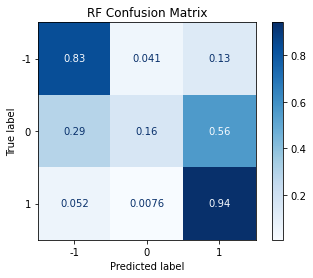

In [25]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("RF Confusion Matrix")

print("RF Confusion Matrix")
print(disp.confusion_matrix)

### GBM

In [24]:
# Training model
# Params Based on previous gridsearch cvs
gbm_model = lgb.LGBMClassifier(learning_rate=0.05,
                               max_depth=20,
                               min_child_samples=15,
                               num_leaves=100,
                               reg_alpha=0.03,
                               random_state=random_state)
gbm_model.fit(training_df[X_cols],training_df[y_col], verbose=20,eval_metric='logloss')

# Testing model
gbm_acc,gbm_f1 = test_model_metrics(gbm_model,"GBM",testing_df[X_cols],testing_df[y_col])

/home/james/miniconda3/envs/ydmads/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


GBM metrics:
Accuracy Score: 0.8461547967720807
F1 score: 0.8213557660023547


GBM Confusion Matrix
[[0.8089129  0.05559307 0.13549404]
 [0.21857128 0.18545284 0.59597588]
 [0.03970462 0.00171112 0.95858426]]


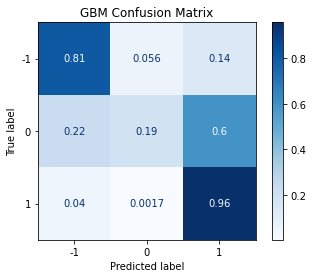

In [26]:
disp = ConfusionMatrixDisplay.from_estimator(
    gbm_model,
    testing_df[X_cols],
    testing_df[y_col],
    cmap=plt.cm.Blues,
    normalize="true",
)
disp.ax_.set_title("GBM Confusion Matrix")

print("GBM Confusion Matrix")
print(disp.confusion_matrix)

### Neural Net
We will use fastai to create a tabular learner neural net

In [1]:
from fastai.tabular.all import *

ModuleNotFoundError: No module named 'fastai'

In [30]:
X_cols

['duration',
 'age_limit',
 'view_count',
 'like_count',
 'view_like_ratio',
 'is_comments_enabled',
 'is_live_content',
 'cat_codes',
 'neu',
 'neg',
 'pos',
 'compound']

In [ ]:
# Based on fastai tutorial docs: https://docs.fast.ai/tabular.learner.html
cat_names = ['age_limit','is_comments_enabled','is_live_content','cat_codes']
cont_names = ['duration', 'view_count', 'like_count','view_like_ratio','neu','neg','pos','compound']
procs = [Categorify, FillMissing, Normalize]
dls = TabularDataLoaders.from_df(df, path, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                                 y_names="salary", valid_idx=list(range(800,1000)), bs=64)
learn = tabular_learner(dls)